In [1]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression

In [2]:
xgb_best_params_full = {'reg_lambda': 5, 'reg_alpha': 0.1, 'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.15250000000000002}

tuned_xgb_model = Pipeline([('impute', KNNImputer(n_neighbors=10)),
                       ('xgb', XGBRegressor(**xgb_best_params_full))])

In [3]:
train_filepath = '../data/data-reduced-train.csv'
test_filepath = '../data/data-reduced-test.csv'
train_data = pd.read_csv(train_filepath)
test_data = pd.read_csv(test_filepath)

features = train_data.columns[4:].to_list()
target = train_data.columns[3]

X_train = train_data[features]
y_train = train_data[target]

X_train_train, X_val, y_train_train, y_val = train_test_split(X_train, y_train,
                                                  test_size=0.2,
                                                  random_state=42) #splitting for evaluating metrics on a validation set

tuned_xgb_model.fit(X_train_train, y_train_train)
val_predictions = tuned_xgb_model.predict(X_val)

#### Here we check three metrics on a validation set before fitting the model to the full training set, for comparsion

In [4]:
metrics = {'Root Mean Squared Error': root_mean_squared_error,
           'Mean Absolute Error': mean_absolute_error,
           'Mean Absolute Percentage Error': mean_absolute_percentage_error}

for name, metric in metrics.items():
    print(f'Validation {name} for XGBoost: {metric(y_val, val_predictions):.4f}')

Validation Root Mean Squared Error for XGBoost: 0.5120
Validation Mean Absolute Error for XGBoost: 0.3910
Validation Mean Absolute Percentage Error for XGBoost: 0.0371


Fit the model to the training set

In [5]:
tuned_xgb_model.fit(X_train, y_train)

Pipeline(steps=[('impute', KNNImputer(n_neighbors=10)),
                ('xgb',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, device=None,
                              early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None,
                              learning_rate=0.15250000000000002, max_bin=None,
                              max_cat_threshold=None, max_cat_to_onehot=None,
                              max_delta_step=None, max_depth=3, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=150, n_jobs=None,
                              num_parallel_tree=None, random_state=None, ...))])

In [6]:
X_test = test_data[features]
y_test = test_data[target]

test_predictions = tuned_xgb_model.predict(X_test)

In [7]:
metrics = {'Root Mean Squared Error': root_mean_squared_error,
           'Mean Absolute Error': mean_absolute_error,
           'Mean Absolute Percentage Error': mean_absolute_percentage_error}

for name, metric in metrics.items():
    print(f'Test {name} for XGBoost: {metric(y_test, test_predictions):.4f}')

Test Root Mean Squared Error for XGBoost: 0.4901
Test Mean Absolute Error for XGBoost: 0.3711
Test Mean Absolute Percentage Error for XGBoost: 0.0351


# Plot of residuals vs predictions on the test set

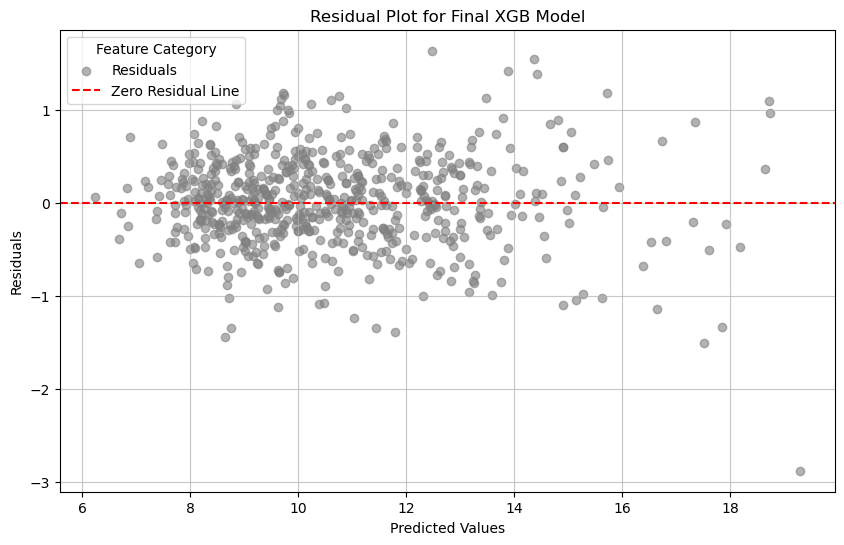

In [11]:
import matplotlib.pyplot as plt

residuals = y_test - test_predictions

plt.figure(figsize=(10, 6))
plt.scatter(test_predictions, residuals, alpha=0.6, label="Residuals", color='gray')
plt.axhline(0, color='red', linestyle='--', label="Zero Residual Line")
plt.title(f"Residual Plot for Final XGB Model")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.legend(title="Feature Category")
plt.grid(alpha=0.7)
plt.show()

# Testing linear regression and our baseline models again

In [8]:
linear_model = Pipeline([('impute', KNNImputer(n_neighbors=10)),
                          ('linreg', LinearRegression())])

linear_model.fit(X_train, y_train)
linear_train_predictions = linear_model.predict(X_train)
linear_test_predictions = linear_model.predict(X_test)

In [9]:
for name, metric in metrics.items():
    print(f'Test {name} for Linear Regression: {metric(y_test, linear_test_predictions):.4f}')

Test Root Mean Squared Error for Linear Regression: 0.5075
Test Mean Absolute Error for Linear Regression: 0.3744
Test Mean Absolute Percentage Error for Linear Regression: 0.0354


## Simple Linear Regression on Obesity

In [10]:
slr = Pipeline([('impute', KNNImputer(n_neighbors=10)),
                #('scale', StandardScaler()), #scaling shouldn't matter for rudimentary analysis, but is included here for consistency
                ('linreg', LinearRegression())])

slr.fit(X_train[['% Adults with Obesity']], y_train)

slr_train_preds = slr.predict(X_train[['% Adults with Obesity']])
slr_test_preds = slr.predict(X_test[['% Adults with Obesity']])

In [11]:
for name, metric in metrics.items():
    print(f'Test {name} for SLR: {metric(y_test, slr_test_preds):.4f}')

Test Root Mean Squared Error for SLR: 1.6966
Test Mean Absolute Error for SLR: 1.3351
Test Mean Absolute Percentage Error for SLR: 0.1263


## Mean Value Model

In [12]:
target_training_mean = np.mean(y_train)

mean_train_preds = target_training_mean*np.ones(y_train.shape)
mean_test_preds = target_training_mean*np.ones(y_test.shape)

In [13]:
for name, metric in metrics.items():
    print(f'Test {name} for Mean Model: {metric(y_test, mean_test_preds):.4f}')

Test Root Mean Squared Error for Mean Model: 2.2563
Test Mean Absolute Error for Mean Model: 1.7618
Test Mean Absolute Percentage Error for Mean Model: 0.1669


## Random sampling model

In [14]:
#model chooses at random from the training set to make predictions
random_test_preds = np.random.choice(y_train, size=y_test.shape)

In [15]:
for name, metric in metrics.items():
    print(f'Test {name} for Random Choice Model: {metric(y_test, random_test_preds):.4f}')

Test Root Mean Squared Error for Random Choice Model: 3.3184
Test Mean Absolute Error for Random Choice Model: 2.5700
Test Mean Absolute Percentage Error for Random Choice Model: 0.2442
